# Construct a binary tree from sklearn decision tree classifier

Sklearn decision trees store their trees as preorder depth first searches. To illustrate how to construct a hierarchical object that can be saved as JSON and loaded to D3, we can look at a simple dataset as the iris.

In [14]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz
import json
from brewer2mpl import qualitative
iris = load_iris()
num_classes = 3
# colors for subsequent decision tree plotting
colors = qualitative.Dark2[num_classes].hex_colors
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

The results are stored in 

In [15]:
clf.tree_.feature

array([ 3, -2,  3,  2,  3, -2, -2,  3, -2,  2, -2, -2,  2,  0, -2, -2, -2])

or here 

In [16]:
clf.tree_.__getstate__()['nodes']

array([( 1,  2,  3,  0.80000001,  0.66666667, 150,  150.),
       (-1, -1, -2, -2.        ,  0.        ,  50,   50.),
       ( 3, 12,  3,  1.75      ,  0.5       , 100,  100.),
       ( 4,  7,  2,  4.94999981,  0.16803841,  54,   54.),
       ( 5,  6,  3,  1.6500001 ,  0.04079861,  48,   48.),
       (-1, -1, -2, -2.        ,  0.        ,  47,   47.),
       (-1, -1, -2, -2.        ,  0.        ,   1,    1.),
       ( 8,  9,  3,  1.54999995,  0.44444444,   6,    6.),
       (-1, -1, -2, -2.        ,  0.        ,   3,    3.),
       (10, 11,  2,  5.44999981,  0.44444444,   3,    3.),
       (-1, -1, -2, -2.        ,  0.        ,   2,    2.),
       (-1, -1, -2, -2.        ,  0.        ,   1,    1.),
       (13, 16,  2,  4.85000038,  0.04253308,  46,   46.),
       (14, 15,  0,  5.94999981,  0.44444444,   3,    3.),
       (-1, -1, -2, -2.        ,  0.        ,   1,    1.),
       (-1, -1, -2, -2.        ,  0.        ,   2,    2.),
       (-1, -1, -2, -2.        ,  0.        ,  43,   43.

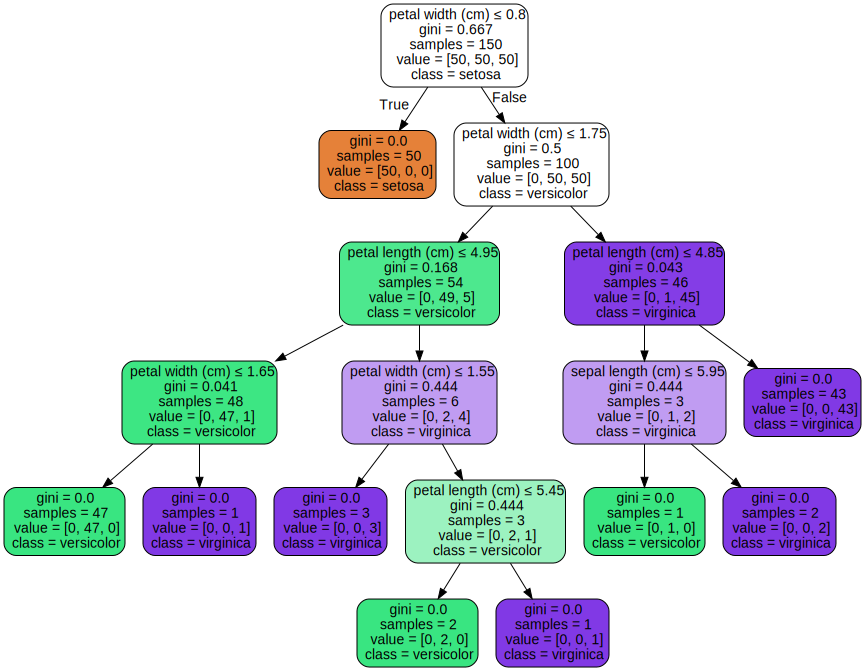

In [17]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## tree construction

We can reconstruct the decision tree by using stacks. Alternatively, we could us recursios.

In [41]:
from collections import deque

# it is currently superfluous to have a node class but might be useful in the future
class Node:
    
    COUNTER = 0
    
    def __init__(self, name):
        self.name = name
        self.children = []
        Node.COUNTER += 1
    
    def add_child(self, child):
        self.children.append(child)

# data for reconstructing the tree
features = clf.tree_.feature
n_samples = clf.tree_.n_node_samples
feature_names = iris.feature_names
values = clf.tree_.value # is it weighted?
thresholds = np.round(clf.tree_.threshold,2)
classes = clf.tree_.predict

# set containers
leaves = deque()
nodes = []

# helper functions
def value_getter(arr):
    return [int(v) for v in arr[0]]


# count the leaf nodes in the tree in order to return a little bit nicer formatted output
n_leaf = sum([feature == -2 for feature in features])

# build the tree in a bottom-up approach
for n, feature in enumerate(reversed(features)):
    this_value = value_getter(values[-(n+1)])
    this_label = feature_names[feature] + '<' + str(thresholds[-(n+1)])
    # if it is a leaf node, append it to leaves and give it a name
    if feature == -2:
        leaf = {'label': 'leaf' + str(n_leaf), 'samples': sum(this_value), 'value': this_value,
                'color': colors[np.argmax(this_value)]}
        leaves.append(leaf)
        n_leaf -= 1
    # if it is a node, append it to the tree
    else:
  #      node = Node(feature_names[feature])
  #      print(node.COUNTER)
  #      nodes.append(node)
        # add left and right children to the stack
        child1=leaves.pop()
        child2=leaves.pop()
        # temporary stack to store the children
        temp_leaves = []
        # and the nodes 
        temp_node_leaves = {'label': this_label , 'samples': sum(this_value), 
                            'value': this_value, 'color': colors[np.argmax(this_value)]}
        temp_leaves.append(child1)
        temp_leaves.append(child2)
        temp_node_leaves['children'] = temp_leaves
        leaves.append(temp_node_leaves)
reconstructed_tree = temp_node_leaves
reconstructed_tree

{'children': [{'color': '#1B9E77',
   'label': 'leaf1',
   'samples': 50,
   'value': [50, 0, 0]},
  {'children': [{'children': [{'children': [{'color': '#D95F02',
         'label': 'leaf2',
         'samples': 47,
         'value': [0, 47, 0]},
        {'color': '#7570B3',
         'label': 'leaf3',
         'samples': 1,
         'value': [0, 0, 1]}],
       'color': '#D95F02',
       'label': 'petal width (cm)<1.65',
       'samples': 48,
       'value': [0, 47, 1]},
      {'children': [{'color': '#7570B3',
         'label': 'leaf4',
         'samples': 3,
         'value': [0, 0, 3]},
        {'children': [{'color': '#D95F02',
           'label': 'leaf5',
           'samples': 2,
           'value': [0, 2, 0]},
          {'color': '#7570B3',
           'label': 'leaf6',
           'samples': 1,
           'value': [0, 0, 1]}],
         'color': '#D95F02',
         'label': 'petal length (cm)<5.45',
         'samples': 3,
         'value': [0, 2, 1]}],
       'color': '#7570B3',
   

Add options for sankey-widget.js

In [45]:
tree = {}
tree['data'] = reconstructed_tree
tree['opts'] = {
      "childrenName": "children", 
      "id": "id", 
      "maxLabelLength": 15, 
      "name": "label", 
      "nodeHeight": None, 
      "tooltip": None, 
      "treeColors": True, 
      "value": "samples"
    }

json_out = {'evals': [], 'jsHooks': [], 'x': tree}

With a little bit nicer formatting, we can see that this corresponds to the structure that d3 tree layout expects.

In [46]:
print(json.dumps(json_out, indent=4)) 

{
    "evals": [],
    "jsHooks": [],
    "x": {
        "data": {
            "label": "petal width (cm)<0.8",
            "samples": 150,
            "value": [
                50,
                50,
                50
            ],
            "color": "#1B9E77",
            "children": [
                {
                    "label": "leaf1",
                    "samples": 50,
                    "value": [
                        50,
                        0,
                        0
                    ],
                    "color": "#1B9E77"
                },
                {
                    "label": "petal width (cm)<1.75",
                    "samples": 100,
                    "value": [
                        0,
                        50,
                        50
                    ],
                    "color": "#D95F02",
                    "children": [
                        {
                            "label": "petal length (cm)<4.95",
              

In [47]:
with open('../data/tree.json', 'w') as fp:
    json.dump(json_out, fp, indent = 4)